# ACSE-7 (Inversion and Optimisation)  <a class="tocSkip"></a>

# Homework Lecture 4: Shape Optimisation (solutions) <a class="tocSkip"></a>
In this tutorial, we will do our first shape optimisation using the gradient based optimisation algorithms covered in lecture 3 and 4. In particular we will discover the importance of accurate derivative information in optimisation algorithms.

<font size="1pt">Some $\LaTeX$ definitions hidden in this cell (double-click to reveal)</font>
$
\newcommand\vec[1]{\mathbf{#1}}
\newcommand\vphi{\boldsymbol{\phi}}
\newcommand\mat[1]{\underline{\mathbf{#1}}}
\newcommand\R{\mathbb{R}}
\newcommand\todo[1]{\textcolor{red}#1}
$

In [16]:
# needs to be in separate cell!
%matplotlib inline

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as sl
import scipy.optimize as sop
from mpltools import annotation  # draws triangles in convergence plots
plt.rcParams['font.size'] = 16
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'Dejavu Sans']

# Verification for area and length functions
In the lecture notes we introduced two functions to compute the area and length (perimeter) of arbitrary polygons. Given the analytical formulae for the perimeter and area of a regular polygon below, test the `area` and `length` functions by comparing the analytical result with the result of the functions for a range of $n$, the number of edges.

\begin{align*}
  p &= 2 n R \sin(\frac{\pi}{n}) \\
  A &= \tfrac 12 nR^2\sin(\frac{2\pi}n)
\end{align*}

Use `regular_polygon` from the lecture notes to generate the polygons.

### Solution <a class="tocSkip"></a>
From the lecture notes:

In [27]:
def regular_polygon(R, n):
    """Create a regular polygon of radius R with n sides"""
    alpha = 2*np.pi/n
    x = []
    for i in range(n+1):
        x.append([R*np.cos(alpha*i), R*np.sin(alpha*i)])
    return np.array(x)

def area(x):
    """Compute the area of the polygon x"""
    n = len(x)-1
    a = 0.
    for i in range(n):
        a += (x[i,0]-x[i+1,0])*(x[i,1]+x[i+1,1])/2.
    return a

def length(x):
    """Compute the length of the path described by the list of points x."""
    n = len(x)-1
    l = 0.
    for i in range(n):
        l += sl.norm(x[i+1]-x[i])
    return l

The code below tests for three different radii, $R=.1, 2,$ and 5, and $3\leq n\leq 10$ :

In [28]:
for R in [.1, 2, 5]:
    for n in range(3, 10):
        p = 2*n*R*np.sin(np.pi/n)
        A = 0.5*n*R**2*np.sin(2*np.pi/n)
        x = regular_polygon(R, n)
        np.isclose(p, length(x))
        np.isclose(A, area(x))
        print(R, n, p, length(x), A, area(x))

0.1 3 0.5196152422706632 0.5196152422706632 0.012990381056766583 0.012990381056766583
0.1 4 0.565685424949238 0.565685424949238 0.020000000000000004 0.020000000000000004
0.1 5 0.5877852522924731 0.5877852522924731 0.023776412907378842 0.023776412907378842
0.1 6 0.6 0.6000000000000001 0.025980762113533163 0.02598076211353316
0.1 7 0.6074372347645814 0.6074372347645814 0.027364101886381047 0.02736410188638105
0.1 8 0.6122934917841437 0.6122934917841436 0.028284271247461905 0.028284271247461905
0.1 9 0.6156362579862037 0.6156362579862037 0.028925442435894275 0.028925442435894268
2 3 10.392304845413264 10.392304845413264 5.196152422706632 5.196152422706632
2 4 11.31370849898476 11.31370849898476 8.0 8.0
2 5 11.755705045849464 11.755705045849464 9.510565162951535 9.510565162951536
2 6 11.999999999999998 12.0 10.392304845413264 10.392304845413264
2 7 12.148744695291628 12.148744695291628 10.945640754552418 10.945640754552418
2 8 12.245869835682873 12.245869835682871 11.31370849898476 11.3137

# Derivative of the Area

Write a function `grad_area` that takes a vector $\vec x\in\R^{(n+1)\times 2}$ (describing a polygon) and returns the derivative of its area with respect to $\vec x$.  The returned derivative should be a $(n+1,2)$ rank-2 array.

Test this derivative function using the Taylor test where you may use the `taylor_test` function from the lecture notes.

If you compare the exact convergence numbers of `grad_area` with those of `grad_length` (in the lecture notes) what do you notice? Can you think of a reason why (what mathematical property of the `area` function causes this) ?


**Hint**: Looking at the `area` function, we see that the area is computed as:

$$
  A = \sum_i A_i,\;\;\text{where}\;
  A_i = \tfrac 12\left(x_{i,0}-x_{i+1,0}\right)\left(x_{i,1}+x_{i+1,1}\right)
$$

based on the explanation for `grad_length`, we can use the following structure

```python
def grad_area(x):
    """Compute the gradient of area(x)."""
    n = len(x)-1
    dadx = np.zeros((n+1, 2))
    for i in range(n):
        dadx[i, 0] += ... # derivative of A_i w.r.t x_{i,0}
        dadx[i+1, 0] += ... # derivative of A_i w.r.t x_{i+1,0}
        dadx[i, 1] += ... # derivative of A_i w.r.t x_{i,1}
        dadx[i+1, 1] += ... # derivative of A_i w.r.t x_{i+1,1}

    return dadx
```



### Solution <a class="tocSkip"></a>
The following function implements the derivative of `area`:

In [29]:
def grad_area(x):
    """Compute the gradient of area(x)."""
    n = len(x)-1
    dadx = np.zeros((n+1, 2))
    for i in range(n):
        dadx[i, 0] += (x[i,1]+x[i+1,1])/2.
        dadx[i+1, 0] += -(x[i,1]+x[i+1,1])/2.
        dadx[i, 1] += (x[i,0]-x[i+1,0])/2.
        dadx[i+1, 1] += (x[i,0]-x[i+1,0])/2.

    return dadx

Copy and paste of `taylor_test` from the lectures notes:

In [30]:
def taylor_test(f, grad_f, x, h0, max_iter=20, plot_convergence=True, print_convergence=True):
    """Taylor test to verify that the function grad_f is the derivative of the function `f`
    
    We test:
    
       f(x + h) = f(x) + grad_f(x).h + O(h^2)
    
    f, grad_f  - function and its derivative to test
    x          - point in which to test
    h0         - initial perturbation
    max_iter   - number of times that h is halved
    plot_convergence - whether to plot the convergence of the Taylor residual f(x+h)-f(x)-grad_f(x).h
    print_convergence - prints the order of convergence between subsequent iterations."""


    h = h0.copy()
    residuals = []
    hnorms = []
    for i in range(max_iter):
        r = f(x + h) - f(x) - np.sum(grad_f(x) * h)
        residuals.append(sl.norm(r))
        hnorms.append(sl.norm(h))
        h /= 2.

    if plot_convergence:
        fig, ax = plt.subplots(1,2, figsize=(16,4))
        ax[0].semilogy(residuals)
        ax[0].set_xlabel('iteration')
        ax[0].set_ylabel('Taylor residual $|r|$')
        ax[0].set_xticks(range(0,max_iter,2))
        ax[1].loglog(hnorms, residuals)
        ax[1].set_xlabel('perturbation size $\|h\|$')
        ax[1].set_ylabel('Taylor residual $|r|$')

        # NOTE: slope_marker does not seem to work in semilogy plots
        annotation.slope_marker((1e-3, 1e-4), (2, 1), invert=True, ax=ax[1], size_frac=.2)

    if print_convergence:
        residuals = np.array(residuals)
        print('Order of convergence, log(r(h_i)/r(h_{i+1}))/log(2):')
        print(np.log(residuals[:-1]/residuals[1:])/np.log(2))

For the taylor test we need to provide an initial perturbation vector which determines the direction in which we perturb the polygon:

Order of convergence, log(r(h_i)/r(h_{i+1}))/log(2):
[2.         2.         2.         2.         2.         2.
 2.         2.         2.         2.00000002 1.99999996 2.00000009
 2.00000018 2.00001232 2.0000087  2.00008112 2.00033222 1.99998464
 1.9931868 ]


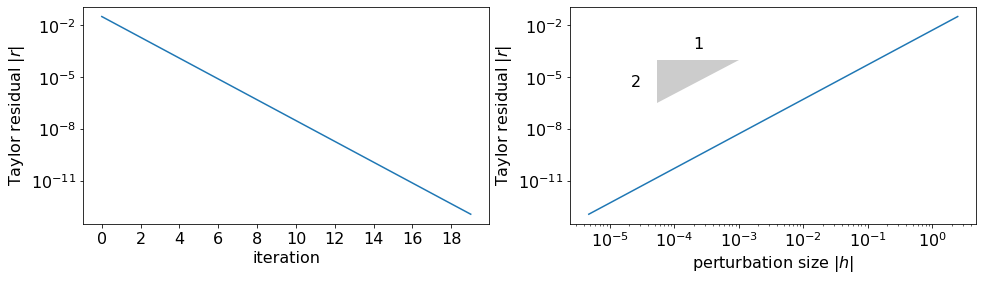

In [31]:
# we test the derivative around a regular polygon
R = 1.5
n = 6
x = regular_polygon(R, n)

# our original perturbation h0 is chosen as a random vector
# with values between 0 and 1
np.random.seed(0)
h0 = np.random.random((n+1, 2))

taylor_test(area, grad_area, x, h0)

The convergence is exactly 2 immediately. This is because `area`$(\vec x)$ is a quadratic function, so the Taylor approximation is exact.

# Shape Factors
Now it's time to figure out what we actually want to optimise for. There are many problems where we want to minimize or maximize geometrical properties such as perimeter, surface area, volume, etc. For instance when designing a container we may want to maximize the volume for optimal storage capacity, and/or minimize its surface area in order to minimize the amount of material that is needed. A classical problem is **Dido's problem** which asks the question: given a fixed amount of fencing (i.e a fixed perimeter length!) what is the maximum area that we can enclose?

This is actually a constrained problem (the constraint is the fixed length of the perimeter) which we will learn about in lecture 6, but we can reformulate it to a problem without constraints using a simple dimensional analysis. If we know what the optimal solution is for a given perimeter, then we may also know what the optimal solution is for a perimeter that is a factor of a hundred times larger. The optimal solution would be obtained by simply scaling all dimensions by a factor of a hundred. After all if the original optimisation problem and the optimal solution are formulated in meters, then if we formulate the problem in centimeters, we expect to get exactly the same optimal solution by just converting from meters to centimeters. This also indicates that the maximal area we find will in fact be larger by a factor of $100^2$.

From this analysis it follows that we obtain different optimal solutions by imposing different fixed perimeters $l$, but in each of the optimal solutions the following ratio should be the same:

$$
  Q = \frac{l}{\sqrt{A}}
$$

If we fix $l$ then minimizing for $Q$ is actually equivalent to maximizing the area $A$. Thus even if we remove the constraint to fix $l$, minimizing for $Q$ should always give us an optimal solution that has a minimal value for $Q$. The solution to the unconstrained problem is non-unique, but if we find one solution we can obtain others by rescaling. So if we require an optimal solution with a certain perimeter, we can obtain it by rescaling.

To compute the *shape factor* $Q$ we want to optimize, we can simply combine the two functions we already have:

In [32]:
def shape_factor(x):
    """Computes the ratio l/sqrt{A}"""
    return length(x)/np.sqrt(area(x))

As you may have guessed, your next task is to write its derivative. You should make your life a lot easier by using the fact that by now we already have derivatives for `length` and `area`, so that the derivative of `shape_factor` can be calculated using the [quotient rule](https://en.wikipedia.org/wiki/Quotient_rule) (or use the product rule on $l\cdot\frac 1{\sqrt{A}}$ if you prefer):

*Write a function `grad_shape_factor` that computes the derivative of `shape_factor` and test it with the Taylor test.*

### Solution <a class="tocSkip"></a>
From the lecture notes:

In [33]:
def grad_length(x):
    """Compute the gradient of length(x)."""
    n = len(x)-1
    dldx = np.zeros((n+1, 2))
    for i in range(n):
        dldx[i, 0] += -(x[i+1,0]-x[i,0])/sl.norm(x[i+1]-x[i])
        dldx[i+1, 0] += (x[i+1,0]-x[i,0])/sl.norm(x[i+1]-x[i])
        dldx[i, 1] += -(x[i+1,1]-x[i,1])/sl.norm(x[i+1]-x[i])
        dldx[i+1, 1] += (x[i+1,1]-x[i,1])/sl.norm(x[i+1]-x[i])
    return dldx

The derivative and its test:

In [34]:
def grad_shape_factor(x):
    dQdx = (grad_length(x) * np.sqrt(area(x)) - length(x)*grad_area(x)/np.sqrt(area(x))/2.)/area(x)
    return dQdx

Order of convergence, log(r(h_i)/r(h_{i+1}))/log(2):
[1.90711954 1.94745542 1.97201987 1.98554933 1.9926543  1.99629633
 1.99814036 1.99906822 1.99953362 1.9997667  1.99988325 1.99994137
 1.99997182 1.99998454 1.99999362 1.99998724 2.00003992 1.99903316
 2.0054012 ]


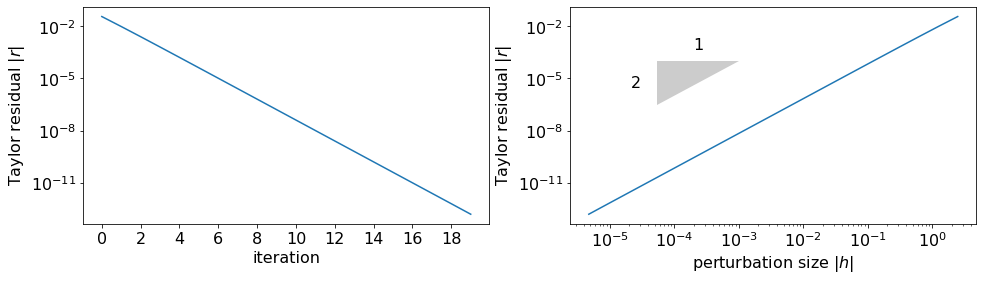

In [35]:
# we test the derivative around a regular polygon
R = 1.5
n = 6
x = regular_polygon(R, n)

# our original perturbation h0 is chosen as a random vector
# with values between 0 and 1
np.random.seed(0)  #  (* see note 2 below)
h0 = np.random.random((n+1, 2))

taylor_test(shape_factor, grad_shape_factor, x, h0)

# Add a Little Class
In principle we now have everything we need to do our first optimisation. Unfortunately, in order for us to make use of scipy's optimisation routines there is still a little bit of plumbing to do. We will be using the function [`minimize`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize). It is a wrapper around a number of optimisation algorithms, a few of which you have now encountered in the lecture. It takes a function, the function to optimise, and our initial guess. We can also provide a derivative function via the `jac=` argument, and a second derivative (if we have one) via the `hess=` argument. During the optimisation the algorithm will call the functions that we have provided, to evaluate the current function value, its gradient (and possibly the second derivative as well) for the various values that $\vec x$ (describing the polygon) achieves during the iterations of the optimisation algorithm.

One issue we have to deal with is that `minimize` expects the vector $\vec x$ to actually be a flat, rank one array, whereas we have been storing it as a rank two array with shape $(n+1, 2)$. This means when it calls the function `shape_factor` which is the function we want to optimize, it will provide it a flat, rank one array of length $2(n+1)$. The same goes for its gradient `grad_shape_factor`, moreover it will expect that function to also return a $2(n+1)$ vector rather than a $(n+1,2)$ array.

Another issue is the fact that the polygon described by the $(n+1,2)$ array is assumed to start and end with the same vertex. If we would allow `minimize` to vary all entries of the array freely, this would no longer be the case. Actually we don't need to vary the location of the first vertex at all: since we don't care about the overall position of the polygon but only its shape, we may as well fix the first vertex. This can be achieved by removing the first and last row from the $(n+1,2)$ array when we form the $\vec x$-vector that is seen by `minimize`. When the `shape_factor` and `grad_shape_factor` functions are called by `minimize` however we do need the position of that vertex to be able to calculate the shape factor and its gradient. We solve this by storing it in an object of `ShapeOptimisationClass` defined below:

In [36]:
class ShapeOptimisationProblem:
    """Shape optimisation based on a polygon.
    
    The first and last vertex of this polygon, described a list of vertices
    should be the same and will not be changed during the optimisation."""
    def __init__(self, x0, f_user, grad_f_user, store_function_evaluations=True, store_gradient_evaluations=True):
        """
        x0     - the initial polygon of n edges, described by a shape (n+1,2) array of vertex positions,
                 where the first and last vertex should be the same to describe a closed polygon
        f_user      - the function that computes the objective values, should take a shape (n+1,2) array
        grad_f_user - function that computes the gradient of f, should take and return a shape (n+1,2) array
        store_function_evaluations, store_gradient_evaluations - if either set to true, self.x_i stores
                                                                 a list of (n+1,2) arrays representing
                                                                 the polygons for which the function or 
                                                                 gradient was evaluated."""        
        self.f_user = f_user
        self.grad_f_user = grad_f_user
        self.x0 = x0.copy()  # we keep a copy of the original polygon
        self.x = x0.copy()  # this is the copy we are actually going to change
        self.n = len(x0)-1
        self.x_i = []  # stores subsequent iterations when asked for
        self.store_function_evaluations = store_function_evaluations
        self.store_gradient_evaluations = store_gradient_evaluations
        
    def minimize(self, *args, **kwargs):
        """Wrapper around scipy.optimize.minimize
        
        Passes the correct function, gradient and initial guess. Any further arguments are also passed on
        to scipy's minimize"""
        # make a copy of x0, so that if we call minimize() again
        # we again start from the same initial guess provided in __init__()
        self.x = self.x0.copy()
        # now turn that into a flat vector
        x0_vec = self.get_x_vec()
        return sop.minimize(self.f, x0_vec, jac=self.jac, *args, **kwargs)
        
    def set_x(self, x_vec):
        """Set self.x based on the 2(n-1) vector used by scipy minimize"""
        # copy into self.x, leaving first and last vertex unchanged:
        self.x[1:self.n, :] = x_vec.reshape((self.n-1, 2))
        
    def get_x_vec(self):
        """Obtain the 2(n-1) vector from self.x"""
        return self.x[1:self.n,:].flatten()  # skip first and last vertex, and flatten
                
    def f(self, x_vec):
        """Wrapper function f, called by scipy's minimize"""
        self.set_x(x_vec)
        if self.store_function_evaluations:
            self.x_i.append(self.x.copy())
        f = self.f_user(self.x)
        return f
    
    def jac(self, x_vec):
        """Wrapper gradient function, called by scipy's minimize"""
        self.set_x(x_vec)
        if self.store_gradient_evaluations:
            self.x_i.append(self.x.copy())
        grad = self.grad_f_user(self.x)
        return grad[1:self.n,:].flatten()  # skip gradient associated with first and last vertex

This class wraps the user provided function and its gradient to ensure the vector seen by `minimize` has the right shape with the first and last vertex removed. In addition, for every call to the function or its gradient, it stores the current value of $\vec x$ so that after the optimisation we can analyze what values $\vec x$ took during the optimisation.

The class also has a `minimize` method which is simply a wrapper to scipy's `minimize` that passes the initial guess, and wrapped `f` and `jac` functions to it. The `*args, **kwargs` in the definition means that any further arguments to `minimize` are passed on to scipy's `minimize`; so we still have the same `method` and  `options` arguments, and any other optional arguments you may find in scipy's [documentation of minimize](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html).

OK, well let's see how that works now:

In [79]:
x0 = np.loadtxt('naca0012.dat')
so = ShapeOptimisationProblem(x0, shape_factor, grad_shape_factor)
result = so.minimize(method='bfgs', options={'maxiter': 2})

We have asked it to do only 2 iterations of BFGS, and if all went well the inbetween values of $\vec x$ should be stored in `so.x_i`. So let's take a look and plot the corresponding polygons:

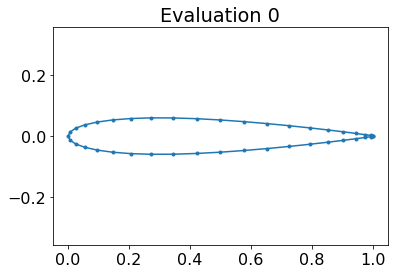

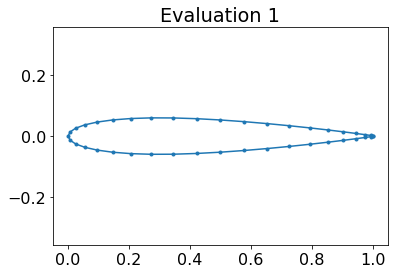

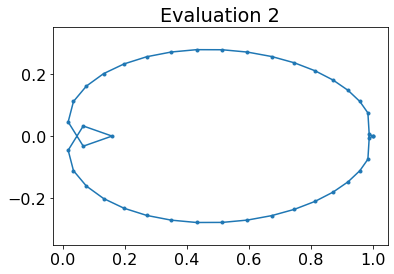

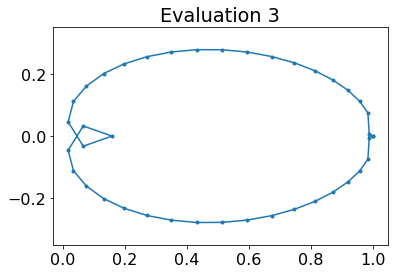

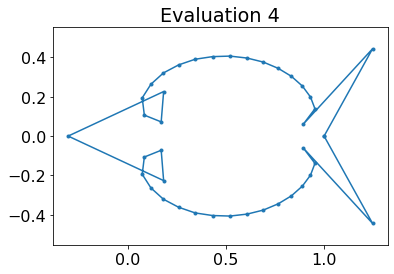

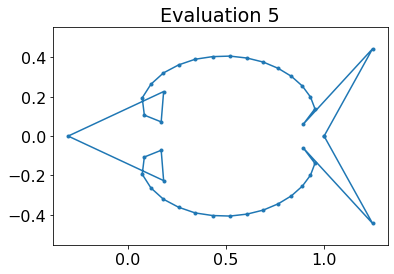

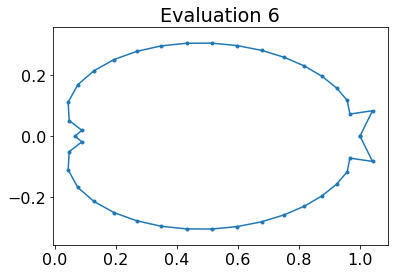

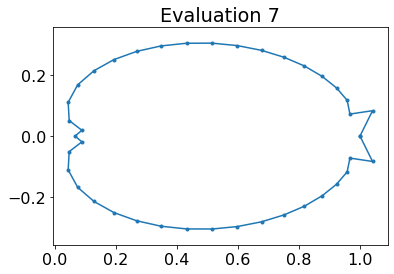

In [80]:
for i, x in enumerate(so.x_i):
    plt.plot(x[:,0], x[:,1], '.-')
    plt.title('Evaluation {}'.format(i))
    plt.axis('equal')
    plt.show()

Note that it has stored 8 evaluations. Whereas we only asked for 2 iterations! The stored evaluations correspond to the value of $\vec x$ on every call of both `shape_factor` and `grad_shape_factor` (you can change that using the `store_function_evaluations` and `store_gradient_evaluations` flags). The reason we get more than expected calls is because a line search in a single iteration may require multiple evaluations.

To figure out exactly what is going on, we can get some more information from the `result` object (see its [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.OptimizeResult.html#scipy.optimize.OptimizeResult) for more details) that is returned by `minimize` :

In [81]:
# prints False because the solver did not satisfy the stopping criterion 
# within the maximum number of iterations (only 2 above)
print("Did the solver succeed:", result['success'])

print("Solver message:", result['message'])

print("Number of iterations:", result['nit'])
print("Number of function evaluations:", result['nfev'])
print("Number of Jacobian evaluations:", result['njev'])

print("Final function value:", result['fun'])

Did the solver succeed: False
Solver message: Maximum number of iterations has been exceeded.
Number of iterations: 2
Number of function evaluations: 4
Number of Jacobian evaluations: 4
Final function value: 4.048242283978987


After all that, now complete the following assignments:

1. You have probably guessed by now what the optimal shape is that minimizes $Q=l/\sqrt{A}$. If not, run the optimisation for longer by removing the maximum number of iterations. Derive an analytical expression for the minimal value of $Q$ that you expect based on this, and compare with what the optimisation achieves as a minimal value for $Q$

2. Although Newton's method requires second derivative information (the Hessian), the `newton-cg` method of `minimize` can be used without providing a Hessian function. If this function is not provided it will  numerically approximate the Hessian by evaluating `jac` and studying its variation when perturbed in different directions, i.e.
$$
  f''(\vec x)\vec h \approx \frac{f'(\vec x+ \vec h) - f'(\vec x)}{\|\vec h\|}
$$
for small vectors $\vec h$ in different directions. Compare the performance of `newton-cg` and `bfgs` in terms of how much time it takes to achieve a certain error and explain the difference (have a close look at the `result` object). Plot the results in a graph with computation time on the $x$-axis vs. error (difference between exact minimum and achieved function value) on the $y$-axis, based on a number of runs with a different number of iterations. You may also include other methods supported by `minimize` (e.g. CG) that are appropriate. For a more "challenging" initial guess you could use the `uk1.dat` and `uk2.dat` (higher resolution) polygons instead of the naca0012.

3. As was mentioned in the lecture, for quasi-Newton secant methods, such as BFGS, the initial scaling is important. This is because when the method starts out, and the Hessian is only poorly approximated, the method is close to Steepest Descent. Try to scale the function by a constant factor (for instance $0.1$) and see if you observe a difference. Since the cost per iteration will be the same, in this case you can simply compare the number of iterations it takes to reach a certain value of $Q$ (iterations it takes to have an error smaller than say 0.05).

### Solutions <a class="tocSkip"></a>

**Answer to 1:** Optimal shape is a circle. Its perimeter (circumference) and area are $l=2\pi R$ and $A=\pi R^2$, so that $Q=2\sqrt{\pi}\approx 3.545$ is the minimal value for $Q$.

**Answer to 2:** Results may vary, but newton-cg is probably going to be quite a bit slower. This is because newton-cg approximates the Hessian as described. Since there are $2(n-1)$ degrees of freedom (where $n=40$ for the naca0012), that means the Jacobian needs to be evaluated quite a lot of times. This can be seen by looking at `results['njev']`.

**Answer to 3:** Using the following code I see with naca0012 and 'bfgs', that it takes $\approx 110$ iterations to reach $Q=3.550$ with `scaling=1`, and with `scaling=0.1` it takes only 40 iterations. So there is a noticeable difference.

In [24]:
scaling = 0.1

def shape_factor_scaled(x):
    """Computes the ratio l/sqrt{A}"""
    return length(x)/np.sqrt(area(x)) * scaling

def grad_shape_factor_scaled(x):
    dfdx = (grad_length(x) * np.sqrt(area(x)) - length(x)*grad_area(x)/np.sqrt(area(x))/2.)/area(x)
    return dfdx * scaling

x0 = np.loadtxt('naca0012.dat')
so = ShapeOptimisationProblem(x0, shape_factor_scaled, grad_shape_factor_scaled)
from timeit import default_timer as timer
time1 = timer()
result = so.minimize(method='bfgs', options={'maxiter': 40})
time2 = timer()
print(result['nit'], result['fun']/scaling, time2-time1)

40 3.5502367340946153 0.16194189398083836


# Aspect Ratio
Of course optimal airfoils are not circular, there are other properties of an airfoil we want to optimize for. In the next part of this coursework, we will look at how to compute lift, the upwards force the flow exerts on the airfoil. Optimising for lift only however, gives rise to some very unphysical solutions. To avoid those, we can add a regularisation term in the objective function that penalizes a solution if it deviates too much from what we think of as a feasible solution. It turns out that the function $Q=l/\sqrt{A}$ that we have studied works very well as a regularisation term. Everything we have derived in this notebook will therefore be needed in the final optimisation.

Again, the cross section of a reasonable airfoil is not a circle. An ellipse with the right aspect ratio however, already looks a lot more like a "natural" airfoil, where the aspect ratio of the ellipse represents the ratio between the front-to-tip length and the thickness of the airfoil.

Area ellipse: 0.07821723252011542
Area NACA0012: 0.08184061082310393


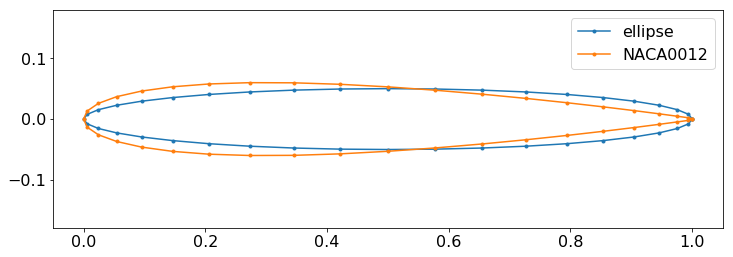

In [25]:
aspect_ratio = 10  # length of 1, and thickness of 0.1
x1 = regular_polygon(0.5, 40)
x1[:,0] += 0.5
x1[:,1] /= aspect_ratio

x2 = np.loadtxt('naca0012.dat')
plt.figure(figsize=(12,4))
plt.plot(x1[:, 0], x1[:, 1], '.-', label='ellipse')
plt.plot(x2[:, 0], x2[:, 1], '.-', label='NACA0012')
plt.legend()
plt.axis('equal')

print('Area ellipse:', area(x1))
print('Area NACA0012:', area(x2))

We can change our function `shape_factor` by scaling the $y$ coordinates of the vertices before the computation. If we multiply the $y$ coordinates by the aspect ratio, then an ellipse like the above is transformed to a circle, and thus this ellipse will have a minimal value returned by `shape_factor`. For this we introduce new versions of `shape_factor` and `grad_shape_factor`:

In [26]:
aspect_ratio = 10.0

def shape_factor_ar(x):
    x[:,1] *= aspect_ratio  # scale y-coordinates: ellipse -> circle
    Q = shape_factor(x)
    x[:,1] /= aspect_ratio   # change back y-coords
    return Q

def grad_shape_factor_ar(x):
    x[:,1] *= aspect_ratio  # scale y coordinates: ellipse -> circle
    dQdx = grad_shape_factor(x)
    x[:,1] /= aspect_ratio  # change back y-coords
    # also rescale the y-derivatives:
    dQdx[:,1] *= aspect_ratio
    return dQdx

Note that we scale the $y$ coordinates back again before exiting the functions, so that we don't mess up any calculations outside of it. In the case of the derivative, `grad_shape_factor_ar` we also need to rescale the "$y$"-derivatives.

That brings us to the final assignment of this notebook:

* Test that `grad_shape_factor_ar` is the correct derivative of `shape_factor_ar`, and use these two functions to perform an actual optimisation that transforms the NACA0012 airfoil into the ellipse shown above with an aspect ratio of 10.

### Solution <a class="tocSkip"></a>

Order of convergence, log(r(h_i)/r(h_{i+1}))/log(2):
[1.85134292 1.95637767 1.98904341 1.99738701 1.99940419 1.99987749
 1.99998222 2.00000193 2.00000366 2.0000025  2.00000139 2.00000103
 2.00000055 1.99999994 1.999986   2.00007838 1.99984225 2.00027653
 2.00084941]


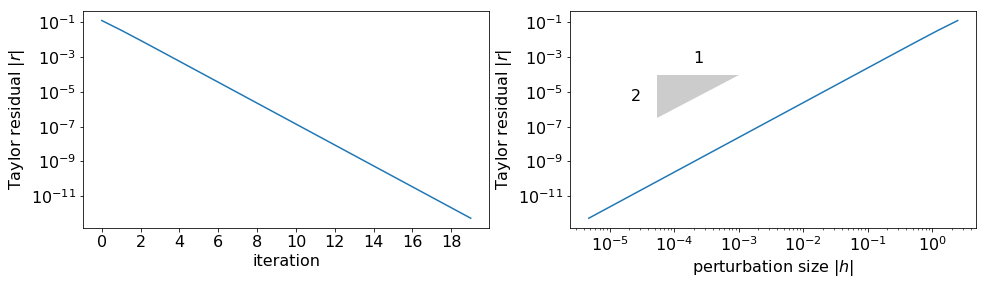

In [27]:
# we test the derivative around a regular polygon
R = 1.5
n = 6
x = regular_polygon(R, n)

# our original perturbation h0 is chosen as a random vector
# with values between 0 and 1
np.random.seed(0)  #  (* see note 2 below)
h0 = np.random.random((n+1, 2))

taylor_test(shape_factor_ar, grad_shape_factor_ar, x, h0)

(3.5485592980801726, 138, 'Optimization terminated successfully.')

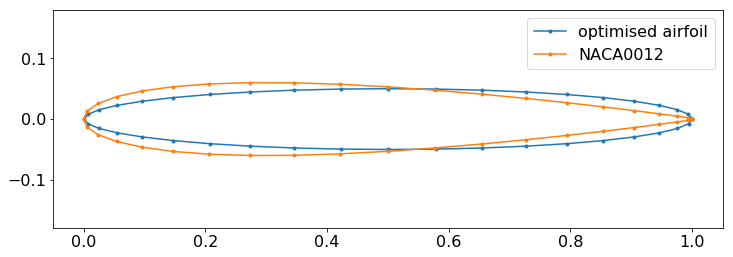

In [28]:
x0 = np.loadtxt('naca0012.dat')
so = ShapeOptimisationProblem(x0, shape_factor_ar, grad_shape_factor_ar)
result = so.minimize(method='bfgs', options={'maxiter':1000})

plt.figure(figsize=(12,4))
plt.plot(so.x[:,0], so.x[:,1], '.-', label='optimised airfoil')
plt.plot(x2[:, 0], x2[:, 1], '.-', label='NACA0012')
plt.legend()
plt.axis('equal')

result['fun'], result['nit'], result['message']